This notebook aims to de-trend renewable energy data by identifying seasonal components and over-time growth

# Import the libraries

In [290]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from time import time
import pyarrow # needed for importing dataframes

# decomposition libs
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.seasonal import DecomposeResult

register_matplotlib_converters()
sns.set_style("darkgrid")

# setup font sizes for images
labelfontsize = 14
ticksfontsize = 12
titlefontsize = 18

# Import the data

In [291]:
years = ['22','23','24'] # all years of actual productions we want
zones = ['IT_NORD'] # focus on only one zone
df_actuals = pd.DataFrame()

# extract all years
for year in years:
    filename = f"lcpb_files/20{year}_actuals.zst"
    df_temp = pd.read_parquet(filename)
    #print(f'rows for year 20{year}: {np.shape(df_temp)[0]}')
    df_actuals = pd.concat([df_actuals, df_temp])

In [292]:
# rename zone to node_id
df_actuals['node_id'] = df_actuals['zone']
df_actuals = df_actuals.drop(columns = ['zone'])

# pick only zones of interest (IT_NORD)
df_actuals = df_actuals[df_actuals['node_id'].isin(zones)]
print('rows in sel_actuals:',np.shape(df_actuals)[0])
df_actuals[:5]

rows in sel_actuals: 26376


,solar,wind,hydro,generation,load,node_id
date_time,,,,,,
2022-01-01 00:00:00+00:00,0.0,2.0,1110.0,6894.0,10583.0,IT_NORD
2022-01-01 01:00:00+00:00,0.0,22.0,1063.0,6297.0,10054.0,IT_NORD
2022-01-01 02:00:00+00:00,0.0,22.0,1057.0,5373.0,9573.0,IT_NORD
2022-01-01 03:00:00+00:00,0.0,22.0,1089.0,4963.0,9402.0,IT_NORD
2022-01-01 04:00:00+00:00,0.0,22.0,1053.0,5405.0,9689.0,IT_NORD


Here we define a growing time parameter normalized from 0 to 1

In [293]:
# sorting for date_time
df_actuals = df_actuals.sort_values(by = 'date_time')
time = []
for i in range(np.shape(df_actuals)[0]):
    time.append(i)
df_actuals['time'] = np.array(time) / max(time)
df_actuals

,solar,wind,hydro,generation,load,node_id,time
date_time,,,,,,,
2022-01-01 00:00:00+00:00,0.0,2.0,1110.0,6894.0,10583.0,IT_NORD,0.000000
2022-01-01 01:00:00+00:00,0.0,22.0,1063.0,6297.0,10054.0,IT_NORD,0.000038
2022-01-01 02:00:00+00:00,0.0,22.0,1057.0,5373.0,9573.0,IT_NORD,0.000076
2022-01-01 03:00:00+00:00,0.0,22.0,1089.0,4963.0,9402.0,IT_NORD,0.000114
2022-01-01 04:00:00+00:00,0.0,22.0,1053.0,5405.0,9689.0,IT_NORD,0.000152
...,...,...,...,...,...,...,...
2024-12-31 22:45:00+00:00,0.0,56.0,1216.0,10158.0,11958.0,IT_NORD,0.999848
2024-12-31 23:00:00+00:00,0.0,8.0,218.0,2110.0,11528.0,IT_NORD,0.999886
2024-12-31 23:15:00+00:00,0.0,8.0,214.0,2095.0,11695.0,IT_NORD,0.999924


Let's try to visualize a feature to see if an actual trend is visible or not

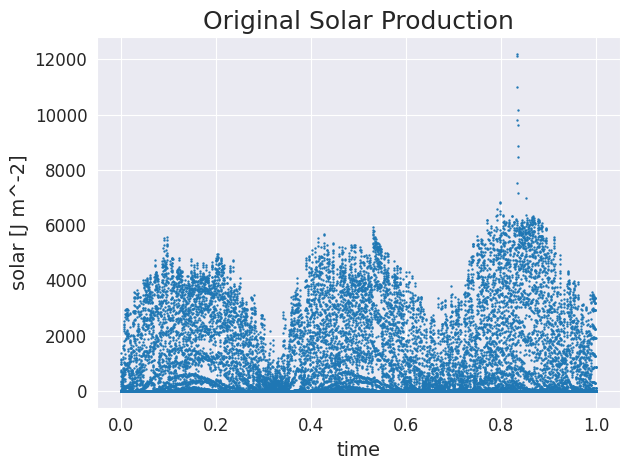

In [294]:
feature = 'solar'
labelfontsize = 14
ticksfontsize = 12
titlefontsize = 18

plt.scatter(df_actuals['time'], df_actuals['solar'], s = 0.5)
plt.title('Original Solar Production', fontsize = 18)
feature = feature + ' [J m^-2]'
plt.xlabel('time', fontsize = labelfontsize)
plt.ylabel(feature, fontsize = labelfontsize)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.tight_layout()
#plt.xlim(199/3/365,202/3/365)
#plt.savefig(f'figures/{feature}_plot.png')
plt.show()


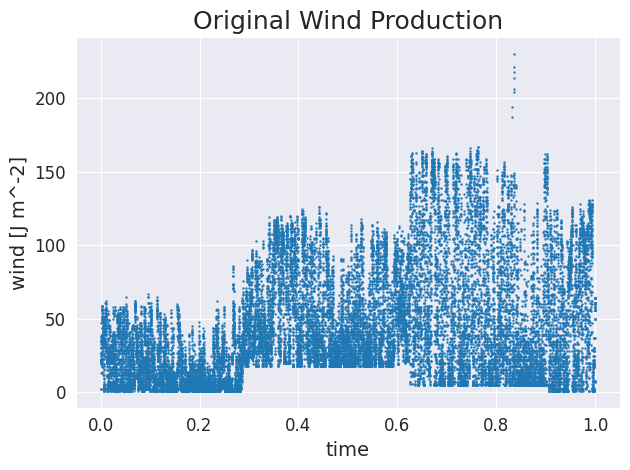

In [295]:
feature = 'wind'
labelfontsize = 14
ticksfontsize = 12
titlefontsize = 18

plt.scatter(df_actuals['time'], df_actuals['wind'], s = 0.5)
plt.title('Original Wind Production', fontsize = 18)
feature = feature + ' [J m^-2]'
plt.xlabel('time', fontsize = labelfontsize)
plt.ylabel(feature, fontsize = labelfontsize)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.tight_layout()
#plt.savefig(f'figures/{feature}_plot.png')
plt.show()

We set all the wind values such that they all start at zero

In [296]:
df_actuals[(df_actuals['time'] >= 0.32) & (df_actuals['time'] <= 0.6)].min()

solar             0.0
wind             18.0
hydro           526.0
generation     3337.0
load           8549.0
node_id       IT_NORD
time             0.32
dtype: object

In [297]:
df_actuals.loc[
    (df_actuals['time'] >= 0.29) & (df_actuals['time'] <= 0.62), 'wind'
] = df_actuals.loc[
    (df_actuals['time'] >= 0.29) & (df_actuals['time'] <= 0.62), 'wind'
] - 18.0

In [298]:
df_actuals[(df_actuals['time'] >= 0.632) & (df_actuals['time'] <= 0.896)].min()

solar             0.0
wind              5.0
hydro           933.0
generation     3774.0
load           8163.0
node_id       IT_NORD
time            0.632
dtype: object

In [299]:
df_actuals.loc[
    (df_actuals['time'] >= 0.632) & (df_actuals['time'] <= 0.896), 'wind'
] = df_actuals.loc[
    (df_actuals['time'] >= 0.632) & (df_actuals['time'] <= 0.896), 'wind'
] - 5.0

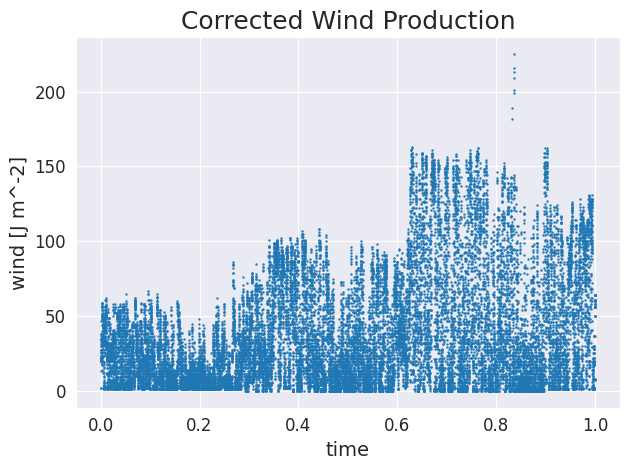

In [300]:
feature = 'wind'
labelfontsize = 14
ticksfontsize = 12
titlefontsize = 18

plt.scatter(df_actuals['time'], df_actuals['wind'], s = 0.5)
plt.title('Corrected Wind Production', fontsize = 18)
feature = feature + ' [J m^-2]'
plt.xlabel('time', fontsize = labelfontsize)
plt.ylabel(feature, fontsize = labelfontsize)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.tight_layout()
#plt.savefig(f'figures/{feature}_plot.png')
plt.show()

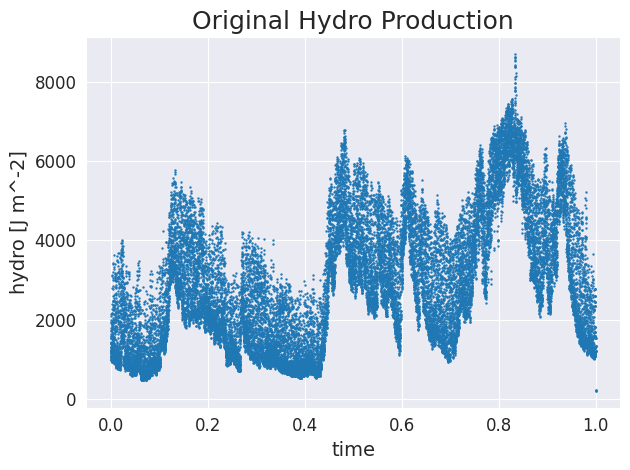

In [301]:
feature = 'hydro'
labelfontsize = 14
ticksfontsize = 12
titlefontsize = 18

plt.scatter(df_actuals['time'], df_actuals['hydro'], s = 0.5)
plt.title('Original Hydro Production', fontsize = 18)
feature = feature + ' [J m^-2]'
plt.xlabel('time', fontsize = labelfontsize)
plt.ylabel(feature, fontsize = labelfontsize)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.tight_layout()
#plt.savefig(f'figures/{feature}_plot.png')
plt.show()

A general growing trend is visible, as well as seasonal trends. We need to de-trend the production training data to "rescale" the data for them to be comparable bewtween different years, regardless of the number of solar/wind power planta installed in the territory. 
To apply the Multiple Seasonal-Trend decomposition it is easier to use hourly timescale (to define periodicities). 


## Making sense of the outliers

There are outliers in the 0.8-0.9 section relative to time. we should consider these later

# De-trending Methods

## De-trending of solar producution data: Multiple Seasonal-Trend decomposition

In [28]:
# checking for NaNs
feature = 'solar'
missing = df_actuals[feature].isna().sum()
print(f"Number of missing values: {missing}")

# checking for missing timestampsfile
expected_range = pd.date_range(start=df_actuals.index.min(), end=df_actuals.index.max(), freq="h")
missing_timestamps = expected_range.difference(df_actuals.index)
print(f"Number of missing timestamps: {len(missing_timestamps)}")

Number of missing values: 0
Number of missing timestamps: 8760


In [29]:
# the time series has hourly frequency, so the decomposition can be performed:
from time import time

mstl = MSTL(df_actuals[feature], 
            periods=[24, # daily frequency
                     24*30, # monthly frequency
                     #24 * 7*, # weekly frequency
                     24 * 365 # yearly frequency
            ]
               ) # seasonal decomposition algorithm
start_time = time()


# res is an instance of a DecomposeResult-like object, not a plain DataFrame but similar... with trend (smoothed long-term trend) , resid (noise or unexplained part), seasonal_period (seasonal components for each period)

res = mstl.fit()  
finish_time = time()
print('total fit time:', round(finish_time - start_time,3), 's')

KeyboardInterrupt: 

In [ ]:
# plot the results
ax = res.plot()
#plt.tight_layout()

In [ ]:
# here we also try with a weekly periodicity (difference between workdays and weekends for ex) and compare results

mstl2 = MSTL(df_actuals[feature], 
            periods=[24, # daily frequency
                     #24*30, #month frequency
                     24 * 7, # weekly frequency
                     24 * 365 # yearly frequency
            ]
               ) # seasonal decomposition algorithm


res2 = mstl2.fit()


In [ ]:
# plot the results
ax = res2.plot()
plt.tight_layout()

No, the first option appears to make more sense, no clear weekly seasonality.

Let's examine the seasonal components in detail

In [ ]:
# daily seasonality
fig, ax = plt.subplots(nrows=3, figsize=[8,6])
res.seasonal["seasonal_24"].iloc[:24*30].plot(ax=ax[0])
ax[0].set_ylabel("seasonal_24")
ax[0].set_title("Daily seasonality")

# weekly seasonality
'''
res.seasonal["seasonal_168"].iloc[:24*7*4].plot(ax=ax[1])
ax[1].set_ylabel("seasonal_168")
ax[1].set_title("Weekly seasonality")'''

# monthly seasonality

res.seasonal["seasonal_720"].iloc[:24*30*12].plot(ax=ax[1])
ax[1].set_ylabel("seasonal_720")
ax[1].set_title("Monthly seasonality")

# yearly seasonality
res.seasonal["seasonal_8760"].iloc[:24*365*3].plot(ax=ax[2])
ax[2].set_ylabel("seasonal_8760")
ax[2].set_title("Yearly seasonality")

plt.tight_layout()

In [ ]:
# SUBTRACTING UNDERLYING TREND TO GET DE-TRENDED SOLAR DATA TO USE

df_actuals_detrended = df_actuals.copy()
df_actuals_detrended['solar']= df_actuals_detrended['solar']- res.trend
df_actuals_detrended

In [ ]:
fig, ax = plt.subplots(nrows=2, figsize=[8,6])

ax[0].scatter(df_actuals['time'], df_actuals['solar'], s = 0.5)
ax[0].set_xlabel('time')
ax[0].set_ylabel('solar')


ax[1].scatter(df_actuals_detrended['time'], df_actuals_detrended['solar'], s = 0.5)
ax[1].set_xlabel('time')
ax[1].set_ylabel('de-trended solar')

plt.show()



PROBLEM: Detrending in this way gives negative values. For example whene there is no production at night, despite more plants being installed over the years, the solar production should remain zero, not become negative. This is due to the trend component starting from 900 and not 0. Thus we subtract from the trend component its initial minimum value (offset), and then substitute with 0 all negative values in the de-trended production data.

In [ ]:
df_actuals_detrended['solar']= df_actuals_detrended['solar'] + np.min(res.trend)
df_actuals_detrended.loc[df_actuals_detrended['solar'] < 0, 'solar'] = 0

In [ ]:
df_actuals_detrended

Let's implement a running average to better compare the difference between original and de-trended data.

In [ ]:
def cumulative_average(df, column): 
    avg = np.zeros(len(df[column]))
    for i in range(len(df[column])):
        avg[i] = np.mean(df[column].iloc[:i])
    return(avg)

detrended_avg = cumulative_average(df_actuals_detrended,'solar')
original_avg =  cumulative_average(df_actuals,'solar')

In [ ]:


fig, ax = plt.subplots(nrows=3, figsize=[8,6])

ax[0].scatter(df_actuals['time'], df_actuals['solar'], s = 0.5)
ax[0].plot(df_actuals['time'],res.trend.values,color='red')
ax[0].set_xlabel('time')
ax[0].set_ylabel('solar')


ax[1].scatter(df_actuals_detrended['time'], df_actuals_detrended['solar'], s = 0.5)
ax[1].set_xlabel('time')
ax[1].set_ylabel('de-trended solar')

ax[2].plot(df_actuals['time'],original_avg, color='red',label='original moving avg')
ax[2].plot(df_actuals_detrended['time'],detrended_avg, color='blue',label='de-trended moving avg')
ax[2].legend()
plt.show()

## De-trending using a Linear Fit instead of MSTL

In [ ]:
slope, intercept = np.polyfit(np.array(df_actuals['time']), np.array(df_actuals['solar']), 1)

Similarly here, we want the linear fit not to be offset (to start from 0 to model only the increase due to more power plant installations), thus we subtract from itself its mininum value (intercept). Then we set to zero all the negative values in the detrended data.

In [ ]:
lin_trend = np.array(df_actuals['time'])*slope
lin_trend = pd.DataFrame( np.vstack([lin_trend,df_actuals['time'].values]).T, index = df_actuals.index, columns= ['linear fit','time'])
lin_trend

In [ ]:

df_lin_detrend = df_actuals['solar']-lin_trend['linear fit']
df_lin_detrend= pd.DataFrame(np.vstack([df_lin_detrend,df_actuals['time'].values]).T, index=lin_trend.index,columns=['solar detrended','time'])
df_lin_detrend.loc[df_lin_detrend['solar detrended'] < 0, 'solar detrended'] = 0
detrended_avg = cumulative_average(df_lin_detrend,'solar detrended')


In [ ]:
fig, ax = plt.subplots(nrows=3, figsize=[8,6])

ax[0].scatter(df_actuals['time'], df_actuals['solar'], s = 0.5)
ax[0].plot(df_actuals['time'],lin_trend['linear fit'],color='red')
ax[0].set_xlabel('time')
ax[0].set_ylabel('solar')
#ax[0].set_ylim(0,1200)

ax[1].scatter(df_lin_detrend['time'], df_lin_detrend['solar detrended'], s = 0.5)
ax[1].set_xlabel('time')
ax[1].set_ylabel('linear de-trended solar')

ax[2].plot(df_actuals['time'],original_avg, color='red',label='original moving avg')
ax[2].plot(df_lin_detrend['time'],detrended_avg, color='blue',label='linear de-trended moving avg')
ax[2].legend()
plt.show()

## De-trending using national installation power data

Another possibility, for the Italian zones forecasting, is using the available total power installation data (in MW) for each year. Only overall national data are available, not divided between market zones, thus we are forced to apprixamate the trend of increasing power installed to be equally distributed among the zones.     

In [ ]:
power_installed = pd.read_csv('lcpb_files/potenze_mw_installato_annuale_italia.csv',delimiter=';')
power_installed = power_installed.iloc[:,0:4]
power_installed

In [ ]:
plt.scatter(power_installed['Anno'],power_installed['Solare'])
xtick = power_installed['Anno']
plt.xlabel('year', fontsize = labelfontsize)
plt.ylabel('solar power installed [MW]', fontsize = labelfontsize)
plt.xticks(xtick,fontsize = ticksfontsize)
plt.yticks(fontsize = ticksfontsize)
plt.title('power installed VS year', fontsize = titlefontsize)
plt.tight_layout()
plt.savefig('figures/power_installed_vs_year.png')
plt.show()

We perform a parabolic fit, normalising both times and power installed in the interval [0:1].  

In [ ]:
power_installed['time'] = np.array((power_installed['Anno']-2020)/4) 
power_installed['Solare'] = np.array((power_installed['Solare']-min(power_installed['Solare']))/ (max(power_installed['Solare'])-min(power_installed['Solare'])))  
power_installed

In [ ]:
a_pw, b_pw, c_pw = np.polyfit(np.array(power_installed['time']), np.array(power_installed['Solare']), 2)
parabolic_trend= df_actuals['time']*b_pw + df_actuals['time']**2 *a_pw  # starts at 0 at t=0 (trend of increase) 

In [ ]:
plt.scatter(power_installed['time'],power_installed['Solare'], label = 'data')
xtick = power_installed['Anno']
plt.xlabel('time', fontsize = labelfontsize)
plt.ylabel('solar power installed [MW]', fontsize = labelfontsize)
plt.xticks(fontsize = ticksfontsize)
plt.yticks(fontsize = ticksfontsize)
plt.title('parabolic fit', fontsize = titlefontsize)
plt.plot(df_actuals['time'], parabolic_trend,color='red', label = 'fit')


fit_text = f'y = ax² + bx + c \na = {round(a_pw,2)}\nb = {round(b_pw,2)}\nc = {round(c_pw,3)}'
plt.text(0.05, 0.95, fit_text, transform=plt.gca().transAxes,
         fontsize=ticksfontsize, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6))


plt.legend(fontsize = ticksfontsize)
plt.tight_layout()
plt.savefig('figures/power_installed_vs_year_fit.png')
plt.show()

We de-trend the production data by subtracting the difference between the average production in the last year and in the first year, rescaled by the parabolic fit of the installed power.  

In [ ]:
first_year_solar_prod_avg = np.mean(df_actuals.loc[df_actuals['time']<1/3,'solar'].values) #prod avg during 2021
last_year_solar_prod_avg=  np.mean(df_actuals.loc[df_actuals['time']>2/3,'solar'].values) #prod avg during 2023
print(first_year_solar_prod_avg,last_year_solar_prod_avg)

In [ ]:
df_power_detrended = df_actuals.copy()
df_power_detrended['solar detrended'] =  df_actuals['solar'] - (last_year_solar_prod_avg-first_year_solar_prod_avg)*parabolic_trend 
df_power_detrended

In [ ]:
df_power_detrended.loc[df_power_detrended['solar detrended']<0,'solar detrended']=0 # fix negative values to 0
df_power_detrended

In [ ]:
cumulative_avg = cumulative_average(df_power_detrended,'solar detrended')

In [ ]:
fig, ax = plt.subplots(nrows=3, figsize=[8,6])

ax[0].scatter(df_actuals['time'], df_actuals['solar'], s = 0.5)
#ax[0].plot(df_actuals['time'],lin_trend['linear fit'],color='red')
ax[0].set_xlabel('time')
ax[0].set_ylabel('solar')


ax[1].scatter(df_power_detrended['time'], df_power_detrended['solar detrended'], s = 0.5)
ax[1].set_xlabel('time')
ax[1].set_ylabel('de-trended solar ')

ax[2].plot(df_actuals['time'],original_avg, color='red',label='original moving avg')
ax[2].plot(df_power_detrended['time'],cumulative_avg, color='blue',label='de-trended moving avg with installed power parabolic fit')
ax[2].legend()

plt.show()

## Trend correction comparison 

In [ ]:
fig,ax= plt.subplots(1,figsize=[9,8])
ax.plot(lin_trend['time'],lin_trend['linear fit'],label='Linear trend correction')
ax.plot(df_power_detrended['time'],(last_year_solar_prod_avg-first_year_solar_prod_avg)*parabolic_trend,label='Parabolic trend correction with installed power data')
ax.plot(df_actuals['time'],res.trend-np.min(res.trend),label='Trend correction with MST decomposition')
ax.set_xlabel('Time')
ax.set_ylabel('Trend correction to Solar production')
plt.legend()


# Producing the MSTL detrended data file
the following code uses MST decomposition and produces a .csv file that contains the detrended data for all production featuresn (only daily and yearly frequencies)


In [ ]:
years = ['22','23','24'] # all years of actual productions we want
zones = ['IT_NORD'] # focus on only one zone
df_actuals = pd.DataFrame()

# extract all years
for year in years:
    filename = f"lcpb_files/20{year}_actuals"
    df_temp = pd.read_parquet(filename)
    #print(f'rows for year 20{year}: {np.shape(df_temp)[0]}')
    df_actuals = pd.concat([df_actuals, df_temp])

# rename zone to node_id
df_actuals['node_id'] = df_actuals['zone']
df_actuals = df_actuals.drop(columns = ['zone'])

# pick only zones of interest (IT_NORD)
df_actuals = df_actuals[df_actuals['node_id'].isin(zones)]
print('selected zone:',zones)
print('rows in sel_actuals:',np.shape(df_actuals)[0])
df_actuals[:5]

# checking for missing timestampsfile
expected_range = pd.date_range(start=df_actuals.index.min(), end=df_actuals.index.max(), freq="h")
missing_timestamps = expected_range.difference(df_actuals.index)
print(f"Number of missing timestamps: {len(missing_timestamps)}")

colors = ['orange','green','blue']

In [ ]:
# features to be detrended
to_detrend = ['solar','wind','hydro']

res = [] # will contain the detrend content

# only daily and yearly frequency
for feature in to_detrend:
    # checking for NaNs
    missing = df_actuals[feature].isna().sum()
    print(f"Number of missing values: {missing}")
    mstl = MSTL(df_actuals[feature], 
                periods=[24, # daily frequency
                         #24*30, # monthly frequency
                         #24 * 7*, # weekly frequency
                         24 * 365 # yearly frequency
                ]
                   ) # seasonal decomposition algorithm
    start_time = time()
    
    
    # res is an instance of a DecomposeResult-like object, not a plain DataFrame but similar... with trend (smoothed long-term trend) , resid (noise or unexplained part), seasonal_period (seasonal components for each period)
    
    res.append(mstl.fit())  
    finish_time = time()
    print('total fit time:', round(finish_time - start_time,3), 's')

## Plot of the features

In [ ]:
# daily seasonality
from matplotlib.ticker import NullFormatter

ticksfontsize = 14

fig, ax = plt.subplots(nrows=4, figsize=[8,14])
plt.suptitle(f"Seasonal Decomposition for {to_detrend[0]}", fontsize=18, y=1.02)

res[0].seasonal["seasonal_24"].iloc[:24*30].plot(ax=ax[0], color = colors[0])
ax[0].xaxis.set_major_formatter(NullFormatter())
ax[0].set_ylabel(f"Daily\nseasonality", fontsize = titlefontsize + 4)
#ax[0].set_title("Daily seasonality")
ax[0].set_xlabel("")
#ax[0].set_xticklabels(['03','10','17','24'])
ax[0].tick_params(labelsize = ticksfontsize)

# weekly seasonality
'''
res.seasonal["seasonal_168"].iloc[:24*7*4].plot(ax=ax[1])
ax[1].set_ylabel("seasonal_168")
ax[1].set_title("Weekly seasonality")'''

# monthly seasonality

'''res.seasonal["seasonal_720"].iloc[:24*30*12].plot(ax=ax[1])
ax[1].set_ylabel("seasonal_720")
ax[1].set_title("Monthly seasonality")'''

# yearly seasonality
res[0].seasonal["seasonal_8760"].iloc[:24*365*3].plot(ax=ax[1],color = colors[0])
ax[1].set_ylabel(f"Yearly\nseasonality", fontsize = titlefontsize + 4)
#ax[1].set_title("Yearly seasonality")
ax[1].set_xlabel("")
ax[1].tick_params(labelsize = ticksfontsize)


res[0].resid.iloc[:24*30*12].plot(ax=ax[2], color = colors[0])
ax[2].set_ylabel("residuals", fontsize = titlefontsize + 4)
#ax[2].set_title("residuals in 12 months")
ax[2].set_xlabel("")
ax[2].tick_params(labelsize = ticksfontsize)

res[0].trend.iloc[:24*30*12*3].plot(ax=ax[3], color = colors[0])
ax[3].set_ylabel("trend", fontsize = titlefontsize + 4)
#ax[3].set_title("3 years trend")
ax[3].set_xlabel("")
ax[3].tick_params(labelsize = ticksfontsize)



plt.tight_layout()

plt.savefig('figures/detrended_solar.png')


### Checking residuals distribution

In [ ]:
### Checking residuals distribution
res[0].resid.hist(bins=50, color = colors[0])
plt.title("Histogram of Residuals")
plt.xlabel("Residual value")
plt.ylabel("Frequency")
plt.show()


Distribution of residuals looks fine (non-seasonal external effects such as climatic)

In [ ]:
# daily seasonality
fig, ax = plt.subplots(nrows=4, figsize=[8,12])
plt.suptitle(f"Seasonal Decomposition for {to_detrend[1]}", fontsize=18, y=1.02)

res[1].seasonal["seasonal_24"].iloc[:24*30].plot(ax=ax[0], color = colors[1])
ax[0].set_ylabel("seasonal_24")
ax[0].set_title("Daily seasonality")

# weekly seasonality
'''
res.seasonal["seasonal_168"].iloc[:24*7*4].plot(ax=ax[1])
ax[1].set_ylabel("seasonal_168")
ax[1].set_title("Weekly seasonality")'''

# monthly seasonality

'''res.seasonal["seasonal_720"].iloc[:24*30*12].plot(ax=ax[1])
ax[1].set_ylabel("seasonal_720")
ax[1].set_title("Monthly seasonality")'''

# yearly seasonality
res[1].seasonal["seasonal_8760"].iloc[:24*365*3].plot(ax=ax[1],color = colors[1])
ax[1].set_ylabel("seasonal_8760")
ax[1].set_title("Yearly seasonality")


res[1].resid.iloc[:24*30*12].plot(ax=ax[2], color = colors[1])
ax[2].set_ylabel("residuals")
ax[2].set_title("residuals in 12 months")

res[1].trend.iloc[:24*30*12*3].plot(ax=ax[3], color = colors[1])
ax[3].set_ylabel("trend")
ax[3].set_title("3 years trend")

plt.tight_layout()

In [ ]:
### Checking residuals distribution
res[1].resid.hist(bins=50, color = colors[1])
plt.title("Histogram of Residuals")
plt.xlabel("Residual value")
plt.ylabel("Frequency")
plt.show()


In [ ]:
# daily seasonality
fig, ax = plt.subplots(nrows=4, figsize=[8,12])
plt.suptitle(f"Seasonal Decomposition for {to_detrend[2]}", fontsize=18, y=1.02)

res[2].seasonal["seasonal_24"].iloc[:24*30].plot(ax=ax[0], color = colors[2])
ax[0].set_ylabel("seasonal_24")
ax[0].set_title("Daily seasonality")

# weekly seasonality
'''
res.seasonal["seasonal_168"].iloc[:24*7*4].plot(ax=ax[1])
ax[1].set_ylabel("seasonal_168")
ax[1].set_title("Weekly seasonality")'''

# monthly seasonality

'''res.seasonal["seasonal_720"].iloc[:24*30*12].plot(ax=ax[1])
ax[1].set_ylabel("seasonal_720")
ax[1].set_title("Monthly seasonality")'''

# yearly seasonality
res[2].seasonal["seasonal_8760"].iloc[:24*365*3].plot(ax=ax[1],color = colors[2])
ax[1].set_ylabel("seasonal_8760")
ax[1].set_title("Yearly seasonality")


res[2].resid.iloc[:24*30*12].plot(ax=ax[2], color = colors[2])
ax[2].set_ylabel("residuals")
ax[2].set_title("residuals in 12 months")

res[2].trend.iloc[:24*30*12*3].plot(ax=ax[3], color = colors[2])
ax[3].set_ylabel("trend")
ax[3].set_title("3 years trend")

plt.tight_layout()

In [ ]:
### Checking residuals distribution
res[2].resid.hist(bins=50, color = colors[2])
plt.title("Histogram of Residuals")
plt.xlabel("Residual value")
plt.ylabel("Frequency")
plt.show()


# Producing detrended dataset

In [43]:

#print(f'offset for {feat}: {min(res[0].trend)}')
#offset = min(res[0].trend)
for i in range(len(to_detrend)):
    offset = min(res[i].trend.iloc[:])
    to_sub = res[i].trend.iloc[:] - offset # offsetting the trend

    detrended = np.where(
        df_actuals[to_detrend[i]] - to_sub > 0, # subtracting detrend values
        df_actuals[to_detrend[i]] - to_sub,
        0 # saving zeros elsewhere
    )
    
    plt.title(f'detrended {to_detrend[i]}')
    plt.ylabel(f'solar {to_detrend[i]}')
    plt.xlabel('normalized time')
    plt.scatter(df_actuals['time'], detrended, s= 0.4)
    plt.show()
    col_name = f'detrended_{to_detrend[i]}'
    df_actuals[col_name] = detrended

filename = 'output/detrended_actuals_MSTL.csv'
df_actuals.to_csv(filename) # saving it


NameError: name 'to_detrend' is not defined

In [ ]:
df_actuals

## Normlization of wind production data with installation power data (WRONG)

Since the trend component obtained with MSTL algorithm goes doen at a certain point, and detrended data still appears to increase significantly over time, we try to de-trend the data using the available installation power data.

In [45]:
df_wind_pow_region = pd.read_csv('wind_power_by_region_and_year.csv')
df_wind_pow_region

FileNotFoundError: [Errno 2] No such file or directory: 'wind_power_by_region_and_year.csv'

In [ ]:
nord_regions = ["Valle d'Aosta", 'Piemonte', 'Liguria','Lombardia', 'Trentino-Alto Adige', 'Veneto', 'Friuli Venezia Giulia', 'Emilia Romagna']
df_wind_pow_nord = df_wind_pow_region[df_wind_pow_region['Region'].isin(nord_regions)]

df_wind_pow_nord = df_wind_pow_nord.iloc[:,:].sum().to_frame().T
df_wind_pow_nord['Region']= 'IT_NORD'
df_wind_pow_nord = pd.melt(df_wind_pow_nord, id_vars=["Region"], var_name="Anno", value_name="Eolica")
df_wind_pow_nord['Anno'] = df_wind_pow_nord['Anno'].astype(int)
df_wind_pow_nord['Eolica'] = pd.to_numeric(df_wind_pow_nord['Eolica'], errors='coerce')
df_wind_pow_nord


In [ ]:
plt.scatter(df_wind_pow_nord['Anno'],df_wind_pow_nord['Eolica'])
xtick = df_wind_pow_nord['Anno']
plt.xlabel('year', fontsize = labelfontsize)
plt.ylabel('wind power installed [MW]', fontsize = labelfontsize)
plt.xticks(xtick,fontsize = ticksfontsize)
plt.yticks(fontsize = ticksfontsize)
plt.title('Wind power installed VS year', fontsize = titlefontsize)
plt.tight_layout()
#plt.savefig('figures/power_installed_vs_year.png')
plt.show()

In [ ]:
#df_wind_pow_nord['Eolica'] = np.array((df_wind_pow_nord['Eolica']-min(df_wind_pow_nord['Eolica']))/ (max(df_wind_pow_nord['Eolica'])-min(df_wind_pow_nord['Eolica'])))  
df_wind_pow_nord['time'] = np.array((df_wind_pow_nord['Anno']-2022)/2) 
df_wind_pow_nord

In [ ]:
a_pw, b_pw = np.polyfit(np.array(df_wind_pow_nord['time']), np.array(df_wind_pow_nord['Eolica']-159), 2)
parabolic_trend = df_actuals['time']**2*a_pw + df_actuals['time']*b_pw + 159  # starts at 0 at t=0 (trend of increase) 

In [ ]:
plt.scatter(df_wind_pow_nord['time'], df_wind_pow_nord['Eolica'], label = 'data')
xtick = df_wind_pow_nord['Anno']
plt.xlabel('time', fontsize = labelfontsize)
plt.ylabel('Wind power installed [MW]', fontsize = labelfontsize)
plt.xticks(fontsize = ticksfontsize)
plt.yticks(fontsize = ticksfontsize)
plt.title('Wind power installation fit', fontsize = titlefontsize)
plt.plot(df_actuals['time'],parabolic_trend,color='red', label = 'fit')


fit_text = f'y = ax^2 + bx+c \na = {round(a_pw,2)}\nb = {round(b_pw,2)}\nc = {round(c_pw,2)}' 
plt.text(0.05, 0.95, fit_text, transform=plt.gca().transAxes,
         fontsize=ticksfontsize, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6))

plt.tight_layout()
#plt.savefig('figures/power_installed_vs_year_fit.png')
plt.show()

In [ ]:
df_actuals['wind detrended']=0.
df_actuals['wind detrended']=df_actuals.loc[df_actuals['time']<0.73,'solar']/parab_fit

In [ ]:
first_year_wind_prod_avg = np.mean(df_actuals.loc[df_actuals['time']<1/3,'wind'].values) #prod avg during 2021
last_year_wind_prod_avg=  np.mean(df_actuals.loc[df_actuals['time']>2/3,'wind'].values) #prod avg during 2023
print(first_year_wind_prod_avg,last_year_wind_prod_avg)

In [ ]:
df_actuals['detrended wind'] =  df_actuals['wind'] - (last_year_wind_prod_avg-first_year_wind_prod_avg)*parabolic_trend 
df_actuals.loc[df_actuals['detrended wind']<0,'detrended wind']=0 # fix negative values to 0
df_actuals

In [ ]:
fig,ax= plt.subplots(1,figsize=[8,6])
ax.plot(df_actuals['time'],(last_year_wind_prod_avg-first_year_wind_prod_avg)*parabolic_trend,label='Parabolic trend correction with installed power data')
#ax.plot(df_actuals['time'],res.trend-np.min(res.trend),label='Trend correction with MST decomposition')
ax.set_xlabel('Time')
ax.set_ylabel('Trend correction to Wind production')
plt.legend()

In [ ]:
filename = 'output/detrended_actuals_MSTL.csv'
df_actuals.to_csv(filename) # saving it

In [ ]:
original_avg =  cumulative_average(df_actuals,'wind')
detrended_avg = cumulative_average(df_actuals,'detrended wind')

In [ ]:
fig, ax = plt.subplots(nrows=3, figsize=[10,10])

ax[0].scatter(df_actuals['time'], df_actuals['wind'], s = 0.5)
ax[0].set_xlabel('time')
ax[0].set_ylabel('wind')


ax[1].scatter(df_actuals['time'], df_actuals['detrended wind'], s = 0.5)
ax[1].set_xlabel('time')
ax[1].set_ylabel('de-trended wind')

ax[2].plot(df_actuals['time'],original_avg, color='red',label='original moving avg')
ax[2].plot(df_actuals['time'],detrended_avg, color='blue',label='de-trended moving avg with installed power parabolic fit')
ax[0].set_xlabel('time')
ax[0].set_ylabel('wind moving avg')
ax[2].legend()

plt.show()

## Normlization of solar production data with installation data

We choose to consider a scaled version of the production data: production divided by the installed power at a given time.

In [58]:
!pip install openpyxl

In [302]:
# solar installation data from 2024
installation_24 = pd.read_excel('lcpb_files/installazioni_mensili_2024.xlsx')
solar_installation_24 = installation_24[installation_24['Fonte']=='Solare']

In [303]:
df_solar_nord_24 = solar_installation_24[solar_installation_24['Zona mercato']=='Nord']
df_solar_nord_24= df_solar_nord_24.sort_values(by='Mese', ascending=True)
df_solar_nord_24['time']= 1.0/3*df_solar_nord_24['Mese']/12 + 2.0/3

In [304]:
df_solar_nord_24 = (df_solar_nord_24.groupby(['time','Anno', 'Mese'], as_index=False)['Potenza attiva nominale (MW)'].sum().sort_values(by='Mese'))
df_solar_nord_24

,time,Anno,Mese,Potenza attiva nominale (MW)
0,0.694444,2024,1.0,307.46006
1,0.722222,2024,2.0,270.70703
2,0.750000,2024,3.0,220.61618
3,0.777778,2024,4.0,186.81141
4,0.805556,2024,5.0,226.75118
5,0.833333,2024,6.0,201.01117
6,0.861111,2024,7.0,201.89090
7,0.888889,2024,8.0,147.71140
8,0.916667,2024,9.0,209.22918
9,0.944444,2024,10.0,220.00089


In [305]:
#df_solar_nord_24['Region'] = 'IT_' + df_solar_nord_24['Zona mercato'].str.upper()
df_solar_nord_24['Solare_installato']= df_solar_nord_24['Potenza attiva nominale (MW)'].cumsum() # cumulative power installed up to that month of 2024
df_solar_nord_24


,time,Anno,Mese,Potenza attiva nominale (MW),Solare_installato
0,0.694444,2024,1.0,307.46006,307.46006
1,0.722222,2024,2.0,270.70703,578.16709
2,0.750000,2024,3.0,220.61618,798.78327
3,0.777778,2024,4.0,186.81141,985.59468
4,0.805556,2024,5.0,226.75118,1212.34586
5,0.833333,2024,6.0,201.01117,1413.35703
6,0.861111,2024,7.0,201.89090,1615.24793
7,0.888889,2024,8.0,147.71140,1762.95933
8,0.916667,2024,9.0,209.22918,1972.18851
9,0.944444,2024,10.0,220.00089,2192.18940


In [306]:
# solar installation data from 2021,2022,2023
df_solar = pd.read_excel('lcpb_files/solare_GSE_2021_2023.xlsx') 

In [307]:
nord_regions = ["Valle d'Aosta", 'Piemonte', 'Liguria','Lombardia', 'Veneto', 'Friuli Venezia Giulia', 'Emilia Romagna','Provincia Autonoma di Bolzano',
'Provincia Autonoma di Trento']
df_solar_nord = df_solar[df_solar['Regione'].isin(nord_regions)]
solar = df_solar_nord.groupby(['Anno'])['Potenza installata (MW)'].agg(Solare_installato ='sum')
df_solar_nord = df_solar_nord.merge(solar, on = ['Anno'], how='left')
df_solar_nord['time']= (df_solar_nord['Anno']-2021)*1.0/3
df_solar_nord= df_solar_nord.drop_duplicates(subset=['Anno', 'time','Solare_installato'])
df_solar_nord= df_solar_nord.drop('Regione',axis=1)
df_solar_nord



,Anno,Potenza installata (MW),Solare_installato,time
0,2021,2270.14,10169.91,0.000000
8,2022,2513.19,11493.82,0.333333
16,2023,3029.70,14563.00,0.666667


In [308]:
df_solar_nord_24['Solare_installato']=  df_solar_nord_24['Solare_installato'] + 14563 # power installed at 2023 + cumulative power installed during 2024
df_solar_nord_24

,time,Anno,Mese,Potenza attiva nominale (MW),Solare_installato
0,0.694444,2024,1.0,307.46006,14870.46006
1,0.722222,2024,2.0,270.70703,15141.16709
2,0.750000,2024,3.0,220.61618,15361.78327
3,0.777778,2024,4.0,186.81141,15548.59468
4,0.805556,2024,5.0,226.75118,15775.34586
5,0.833333,2024,6.0,201.01117,15976.35703
6,0.861111,2024,7.0,201.89090,16178.24793
7,0.888889,2024,8.0,147.71140,16325.95933
8,0.916667,2024,9.0,209.22918,16535.18851
9,0.944444,2024,10.0,220.00089,16755.18940


In [309]:
df_solar_nord = df_solar_nord[['time', 'Anno', 'Solare_installato']]  # from 2021–2023
df_solar_nord_24 = df_solar_nord_24[['time', 'Anno', 'Solare_installato']]  # from 2024

# concatenate
df_solar_nord = pd.concat([df_solar_nord, df_solar_nord_24], ignore_index=True)
df_solar_nord

,time,Anno,Solare_installato
0,0.000000,2021,10169.91000
1,0.333333,2022,11493.82000
2,0.666667,2023,14563.00000
3,0.694444,2024,14870.46006
4,0.722222,2024,15141.16709
5,0.750000,2024,15361.78327
6,0.777778,2024,15548.59468
7,0.805556,2024,15775.34586
8,0.833333,2024,15976.35703
9,0.861111,2024,16178.24793


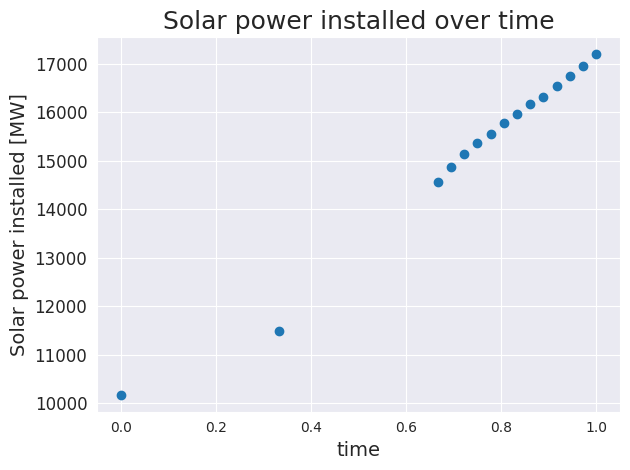

In [310]:
plt.scatter(df_solar_nord['time'],df_solar_nord['Solare_installato'])
xtick = df_solar_nord['Anno']
plt.xlabel('time', fontsize = labelfontsize)
plt.ylabel('Solar power installed [MW]', fontsize = labelfontsize)
plt.yticks(fontsize = ticksfontsize)
plt.title('Solar power installed over time', fontsize = titlefontsize)
plt.tight_layout()

plt.show()

In [311]:
c_parab = df_solar_nord[df_solar_nord['Anno']==2021]['Solare_installato'].values[0]
y_parab = np.array(df_solar_nord[df_solar_nord['time'] < 0.73]['Solare_installato'])- c_parab
a_parab,b_parab = np.polyfit(np.array(df_solar_nord[df_solar_nord['time'] < 0.73]['time']), np.array(y_parab), 2)[0:2]
parab_fit = df_actuals['time']**2*a_parab + b_parab*df_actuals['time'] + c_parab

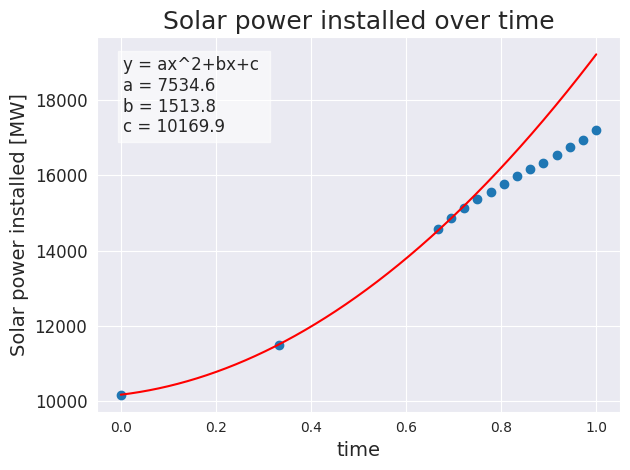

In [312]:
plt.scatter(df_solar_nord['time'],df_solar_nord['Solare_installato'])
plt.plot(df_actuals['time'],parab_fit,color='red',label='Parabolic fit')
xtick = df_solar_nord['Anno']
plt.xlabel('time', fontsize = labelfontsize)
plt.ylabel('Solar power installed [MW]', fontsize = labelfontsize)
plt.yticks(fontsize = ticksfontsize)
plt.title('Solar power installed over time', fontsize = titlefontsize)
plt.tight_layout()

fit_text = f'y = ax^2+bx+c \na = {round(a_parab,1)}\nb = {round(b_parab,1)}\nc = {round(c_parab,1)}' 
plt.text(0.05, 0.95, fit_text, transform=plt.gca().transAxes,
         fontsize=ticksfontsize, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6))
plt.show()

In [382]:
b_linear = df_solar_nord.iloc[4]['Solare_installato']
y_linear = np.array(df_solar_nord[df_solar_nord['time'] > 0.72]['Solare_installato']) - b_linear
a_linear = np.polyfit(np.array(df_solar_nord[df_solar_nord['time'] > 0.72]['time']), np.array(y_linear), 1)[0]
linear_fit = (df_actuals[df_actuals['time'] > 0.72]['time']-0.722222)*a_linear + b_linear


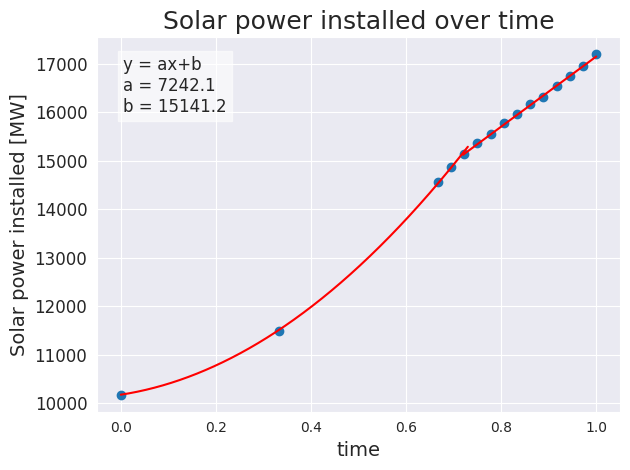

In [314]:
plt.scatter(df_solar_nord['time'],df_solar_nord['Solare_installato'])
plt.plot(df_actuals[df_actuals['time'] > 0.72]['time'],linear_fit,color='red',label='Linear fit')
x=df_actuals[df_actuals['time'] < 0.73]['time']
plt.plot(x,parab_fit[:len(x)],color='red',label='Parabolic fit')
xtick = df_solar_nord['Anno']
plt.xlabel('time', fontsize = labelfontsize)
plt.ylabel('Solar power installed [MW]', fontsize = labelfontsize)
plt.yticks(fontsize = ticksfontsize)
plt.title('Solar power installed over time', fontsize = titlefontsize)
plt.tight_layout()

fit_text = f'y = ax+b \na = {round(a_linear,1)}\nb = {round(b_linear,1)}' 
plt.text(0.05, 0.95, fit_text, transform=plt.gca().transAxes,
         fontsize=ticksfontsize, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6))
plt.show()

In [315]:
df_actuals['detrended_solar']=0.
df_actuals.loc[df_actuals['time']<0.7222,'detrended_solar']=df_actuals.loc[df_actuals['time']<0.73,'solar']/parab_fit
df_actuals.loc[df_actuals['time']>0.7221,'detrended_solar']=df_actuals.loc[df_actuals['time']>0.72,'solar']/linear_fit
df_actuals['detrended_solar']

date_time
2022-01-01 00:00:00+00:00    0.0
2022-01-01 01:00:00+00:00    0.0
2022-01-01 02:00:00+00:00    0.0
2022-01-01 03:00:00+00:00    0.0
2022-01-01 04:00:00+00:00    0.0
                            ... 
2024-12-31 22:45:00+00:00    0.0
2024-12-31 23:00:00+00:00    0.0
2024-12-31 23:15:00+00:00    0.0
2024-12-31 23:30:00+00:00    0.0
2024-12-31 23:45:00+00:00    0.0
Name: detrended_solar, Length: 26376, dtype: float64

In [316]:
def cumulative_average(df, column): 
    avg = np.zeros(len(df[column]))
    for i in range(len(df[column])):
        avg[i] = np.mean(df[column].iloc[:i])
    return(avg)

detrended_avg = cumulative_average(df_actuals,'detrended_solar')
original_avg =  cumulative_average(df_actuals,'detrended_solar')

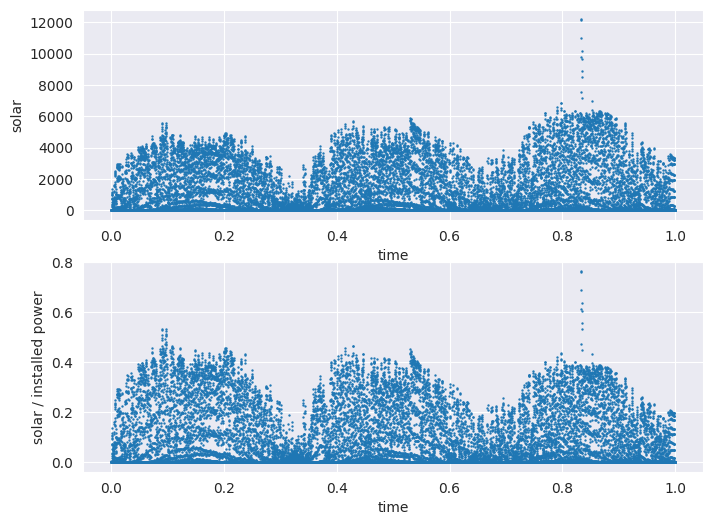

In [317]:
fig, ax = plt.subplots(nrows=2, figsize=[8,6])

ax[0].scatter(df_actuals['time'], df_actuals['solar'], s = 0.5)

ax[0].set_xlabel('time')
ax[0].set_ylabel('solar')

ax[1].scatter(df_actuals['time'], df_actuals['detrended_solar'], s = 0.5)
ax[1].set_xlabel('time')
ax[1].set_ylabel('solar / installed power')

plt.show()

In [318]:
df_actuals['detrended_solar'] = df_actuals.loc[df_actuals['detrended_solar']<0.5,'detrended_solar']

## Normalization of wind production data using installation data 

PRIMA VANNO SISTEMATI GLI ACTUALS DI WIND (TOGLIERE OFFSETS)

In [319]:
df_wind = pd.read_csv('lcpb_files/eolico_GSE_2021_2023.csv',delimiter=';')  #GSE 2021-2023 data
df_wind

,Regione,Valore,Anno
0,Piemonte,19,2021
1,Valle d'Aosta,3,2021
2,Lombardia,0,2021
3,Provincia di Bolzano,0,2021
4,Provincia di Trento,0,2021
...,...,...,...
58,Puglia,3107,2023
59,Basilicata,1496,2023
60,Calabria,1206,2023
61,Sicilia,2277,2023


In [320]:
nord_regions = ["Valle d'Aosta", 'Piemonte', 'Liguria','Lombardia', 'Veneto', 'Friuli Venezia Giulia', 'Emilia Romagna','Provincia Autonoma di Bolzano',
'Provincia Autonoma di Trento']
df_wind_nord = df_wind[df_wind['Regione'].isin(nord_regions)]
wind = df_wind_nord.groupby(['Anno'])['Valore'].agg(Eolico_installato ='sum')
df_wind_nord = df_wind_nord.merge(wind, on = ['Anno'], how='left')
df_wind_nord['time']= (df_wind_nord['Anno']-2021)*1.0/3
df_wind_nord= df_wind_nord.drop_duplicates(subset=['Anno', 'time','Eolico_installato'])
df_wind_nord= df_wind_nord.drop('Regione',axis=1)
df_wind_nord


,Valore,Anno,Eolico_installato,time
0,19,2021,167,0.000000
7,19,2022,199,0.333333
14,19,2023,201,0.666667


In [321]:
wind_installation_24 = installation_24[installation_24['Fonte']=='Eolico'] # GSE wind power installation 2024

In [322]:
df_wind_nord_24 = wind_installation_24[wind_installation_24['Zona mercato']=='Nord']
df_wind_nord_24 = df_wind_nord_24.sort_values(by='Mese', ascending=True)
df_wind_nord_24['time']= 1.0/3*df_wind_nord_24['Mese']/12 + 2.0/3
df_wind_nord_24

,Anno,Mese,Zona mercato,Regione,Provincia,Classe di potenza,Fonte,Livello tensione,Potenza attiva nominale (MW),time
4562,2024,1.0,Nord,Liguria,Savona,1MW<=P<=10MW,Eolico,MT,4.2600,0.694444
4563,2024,3.0,Nord,Liguria,Savona,1MW<=P<=10MW,Eolico,MT,6.0000,0.750000
4561,2024,12.0,Nord,Friuli Venezia Giulia,Trieste,6kW<P<=20kW,Eolico,MT,0.0108,1.000000


In [323]:
df_wind_nord_24 = (df_wind_nord_24.groupby(['time','Anno', 'Mese'], as_index=False)['Potenza attiva nominale (MW)'].sum().sort_values(by='Mese'))
df_wind_nord_24['Eolico_installato']= df_wind_nord_24['Potenza attiva nominale (MW)'].cumsum() # cumulative power installed up to that month of 2024
df_wind_nord_24

,time,Anno,Mese,Potenza attiva nominale (MW),Eolico_installato
0,0.694444,2024,1.0,4.2600,4.2600
1,0.750000,2024,3.0,6.0000,10.2600
2,1.000000,2024,12.0,0.0108,10.2708


In [324]:
df_wind_nord_24['Eolico_installato']=  df_wind_nord_24['Eolico_installato'] + 201 # power installed at 2023 + cumulative power installed during 2024
df_wind_nord_24

,time,Anno,Mese,Potenza attiva nominale (MW),Eolico_installato
0,0.694444,2024,1.0,4.2600,205.2600
1,0.750000,2024,3.0,6.0000,211.2600
2,1.000000,2024,12.0,0.0108,211.2708


In [325]:
df_wind_nord = df_wind_nord[['time', 'Anno', 'Eolico_installato']]  # from 2021–2023
df_wind_nord_24 = df_wind_nord_24[['time', 'Anno', 'Eolico_installato']]  # from 2024
df_wind_nord = pd.concat([df_wind_nord, df_wind_nord_24], ignore_index=True)
df_wind_nord # complete wind installation dataframe

,time,Anno,Eolico_installato
0,0.000000,2021,167.0000
1,0.333333,2022,199.0000
2,0.666667,2023,201.0000
3,0.694444,2024,205.2600
4,0.750000,2024,211.2600
5,1.000000,2024,211.2708


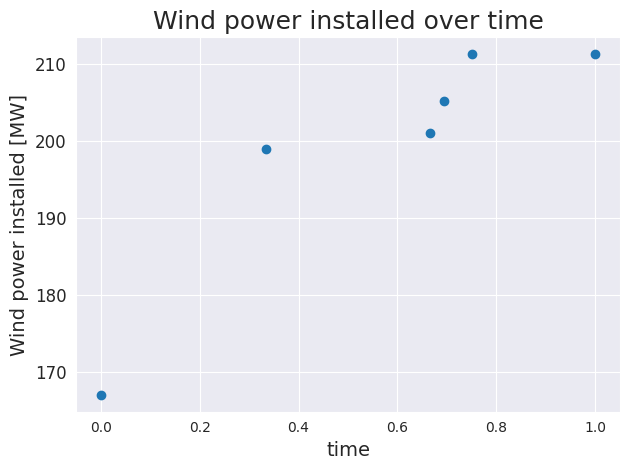

In [326]:
plt.scatter(df_wind_nord['time'],df_wind_nord['Eolico_installato'])
xtick = df_wind_nord['Anno']
plt.xlabel('time', fontsize = labelfontsize)
plt.ylabel('Wind power installed [MW]', fontsize = labelfontsize)
plt.yticks(fontsize = ticksfontsize)
plt.title('Wind power installed over time', fontsize = titlefontsize)
plt.tight_layout()

plt.show()

In [327]:
c_parab = df_wind_nord[df_wind_nord['Anno']==2021]['Eolico_installato'].values[0]
y_parab = np.array(df_wind_nord[df_wind_nord['time'] < 0.6668]['Eolico_installato'])- c_parab
a_parab,b_parab = np.polyfit(np.array(df_wind_nord[df_wind_nord['time'] < 0.6668]['time']), np.array(y_parab), 2)[0:2]
parab_fit = df_actuals['time']**2*a_parab + b_parab*df_actuals['time'] + c_parab

In [328]:
b_linear = df_wind_nord.iloc[2]['Eolico_installato']
y_linear = np.array(df_wind_nord[df_wind_nord['time'] > 0.6667]['Eolico_installato']) - b_linear
a_linear = np.polyfit(np.array(df_wind_nord[df_wind_nord['time'] > 0.6667]['time']), np.array(y_linear), 1)[0]
linear_fit = (df_actuals[df_actuals['time'] > 0.66]['time']-0.666667)*a_linear + b_linear

In [329]:
df_actuals['detrended_wind']=0.0
df_actuals.loc[df_actuals['time']<0.6668,'detrended_wind']=df_actuals.loc[df_actuals['time']<0.6668,'hydro']/parab_fit
df_actuals.loc[(df_actuals['time']>0.6667)&(df_actuals['time']<0.751),'detrended_wind']=df_actuals.loc[(df_actuals['time']>0.6667)&(df_actuals['time']<0.751),'hydro']/linear_fit
df_actuals.loc[df_actuals['time']>0.752,'detrended_wind']=df_actuals.loc[df_actuals['time']>0.752,'hydro']/211.265

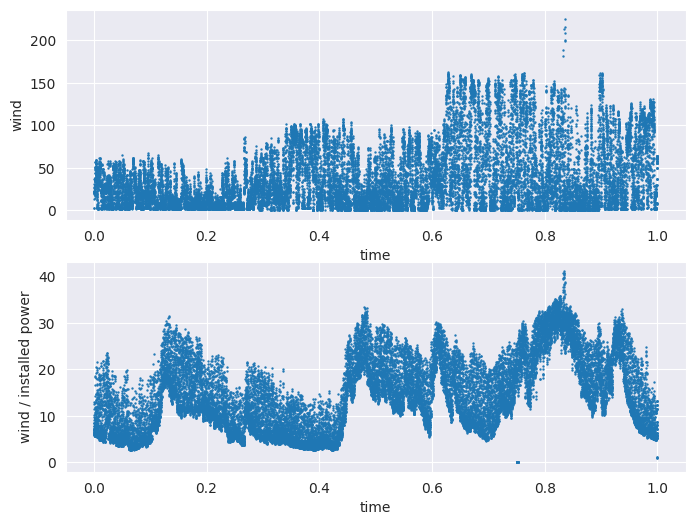

date_time
2022-01-01 00:00:00+00:00    6.646707
2022-01-01 01:00:00+00:00    6.365066
2022-01-01 02:00:00+00:00    6.328936
2022-01-01 03:00:00+00:00    6.520332
2022-01-01 04:00:00+00:00    6.304582
                               ...   
2024-12-31 22:45:00+00:00    5.755804
2024-12-31 23:00:00+00:00    1.031879
2024-12-31 23:15:00+00:00    1.012946
2024-12-31 23:30:00+00:00    0.956145
2024-12-31 23:45:00+00:00    0.960879
Name: detrended_wind, Length: 26376, dtype: float64

In [330]:
fig, ax = plt.subplots(nrows=2, figsize=[8,6])

ax[0].scatter(df_actuals['time'], df_actuals['wind'], s = 0.5)

ax[0].set_xlabel('time')
ax[0].set_ylabel('wind')

ax[1].scatter(df_actuals['time'], df_actuals['detrended_wind'], s = 0.5)
ax[1].set_xlabel('time')
ax[1].set_ylabel('wind / installed power')

plt.show()
df_actuals['detrended_wind']

## Normalization of hydro production data using power installation data

In [341]:
df_hydro = pd.read_excel('lcpb_files/idrico_GSE_2021_2023.xlsx')  # GSE 2021-2023 hydro data
df_hydro

,Regione,Anno,Idrico
0,Piemonte,2021,2799
1,Valle d'Aosta,2021,1025
2,Lombardia,2021,5190
3,Provincia di Bolzano,2021,1767
4,Provincia di Trento,2021,1642
...,...,...,...
58,Puglia,2023,4
59,Basilicata,2023,136
60,Calabria,2023,794
61,Sicilia,2023,152


In [342]:
df_hydro_nord = df_hydro[df_hydro['Regione'].isin(nord_regions)]
hydro = df_hydro_nord.groupby(['Anno'])['Idrico'].agg(Idrico_installato ='sum')
df_hydro_nord = df_hydro_nord.merge(hydro, on = ['Anno'], how='left')
df_hydro_nord['time']= (df_hydro_nord['Anno']-2021)*1.0/3
df_hydro_nord= df_hydro_nord.drop_duplicates(subset=['Anno', 'time','Idrico_installato'])
df_hydro_nord= df_hydro_nord.drop('Regione',axis=1)
df_hydro_nord= df_hydro_nord.drop('Idrico',axis=1)
df_hydro_nord


,Anno,Idrico_installato,time
0,2021,11174,0.000000
7,2022,11217,0.333333
14,2023,11254,0.666667


In [343]:
hydro_installation_24 = installation_24[installation_24['Fonte']=='Idroelettrico'] #2024 gse data
hydro_installation_24

,Anno,Mese,Zona mercato,Regione,Provincia,Classe di potenza,Fonte,Livello tensione,Potenza attiva nominale (MW)
4363,2024,9.0,Centro Sud,Lazio,Rieti,20kW<P<=90kW,Idroelettrico,BT,0.1500
4367,2024,12.0,Calabria,Calabria,Crotone,90kW<P<=200kW,Idroelettrico,BT,0.1000
4371,2024,7.0,Nord,Lombardia,Milano,90kW<P<=200kW,Idroelettrico,BT,0.1000
4372,2024,3.0,Nord,Lombardia,Sondrio,90kW<P<=200kW,Idroelettrico,BT,0.1000
4392,2024,9.0,Nord,Piemonte,Torino,200kW<P<1MW,Idroelettrico,MT,0.8100
4395,2024,3.0,Sud,Basilicata,Potenza,200kW<P<1MW,Idroelettrico,MT,0.3000
4413,2024,8.0,Calabria,Calabria,Cosenza,200kW<P<1MW,Idroelettrico,MT,0.9950
4414,2024,11.0,Centro Nord,Toscana,Firenze,1MW<=P<=10MW,Idroelettrico,MT,1.4640
4415,2024,10.0,Centro Nord,Toscana,Firenze,1MW<=P<=10MW,Idroelettrico,MT,1.4640
4417,2024,10.0,Centro Nord,Toscana,Pistoia,20kW<P<=90kW,Idroelettrico,BT,0.0300


In [344]:
df_hydro_nord_24 = hydro_installation_24[hydro_installation_24['Zona mercato']=='Nord']
df_hydro_nord_24 = df_hydro_nord_24.sort_values(by='Mese', ascending=True)
df_hydro_nord_24['time']= 1.0/3*df_hydro_nord_24['Mese']/12 + 2.0/3
df_hydro_nord_24

,Anno,Mese,Zona mercato,Regione,Provincia,Classe di potenza,Fonte,Livello tensione,Potenza attiva nominale (MW),time
4497,2024,1.0,Nord,Liguria,Savona,200kW<P<1MW,Idroelettrico,MT,0.7500,0.694444
4508,2024,1.0,Nord,Trentino Alto Adige,Trento,90kW<P<=200kW,Idroelettrico,BT,0.1300,0.694444
4520,2024,1.0,Nord,Piemonte,Torino,20kW<P<=90kW,Idroelettrico,BT,0.0300,0.694444
4521,2024,1.0,Nord,Piemonte,Torino,200kW<P<1MW,Idroelettrico,MT,0.5440,0.694444
4528,2024,1.0,Nord,Piemonte,Cuneo,200kW<P<1MW,Idroelettrico,MT,0.2200,0.694444
4515,2024,2.0,Nord,Piemonte,Vercelli,90kW<P<=200kW,Idroelettrico,BT,0.1050,0.722222
4501,2024,2.0,Nord,Trentino Alto Adige,Trento,6kW<P<=20kW,Idroelettrico,BT,0.0150,0.722222
4489,2024,2.0,Nord,Friuli Venezia Giulia,Pordenone,20kW<P<=90kW,Idroelettrico,BT,0.0250,0.722222
4522,2024,2.0,Nord,Piemonte,Cuneo,20kW<P<=90kW,Idroelettrico,BT,0.0900,0.722222
4492,2024,3.0,Nord,Lombardia,Milano,200kW<P<1MW,Idroelettrico,MT,0.2490,0.750000


In [345]:
df_hydro_nord_24 = (df_hydro_nord_24.groupby(['time','Anno', 'Mese'], as_index=False)['Potenza attiva nominale (MW)'].sum().sort_values(by='Mese'))
df_hydro_nord_24['Idrico_installato']= df_hydro_nord_24['Potenza attiva nominale (MW)'].cumsum() # cumulative power installed up to that month of 2024
df_hydro_nord_24

,time,Anno,Mese,Potenza attiva nominale (MW),Idrico_installato
0,0.694444,2024,1.0,1.6740,1.6740
1,0.722222,2024,2.0,0.2350,1.9090
2,0.750000,2024,3.0,0.8590,2.7680
3,0.777778,2024,4.0,0.5000,3.2680
4,0.805556,2024,5.0,2.6500,5.9180
5,0.833333,2024,6.0,4.4090,10.3270
6,0.861111,2024,7.0,1.2700,11.5970
7,0.888889,2024,8.0,0.4707,12.0677
8,0.916667,2024,9.0,2.8000,14.8677
9,0.944444,2024,10.0,4.7140,19.5817


In [346]:
df_hydro_nord_24['Idrico_installato']=  df_hydro_nord_24['Idrico_installato'] + 11254 # power installed at 2023 + cumulative power installed during 2024
df_hydro_nord_24

,time,Anno,Mese,Potenza attiva nominale (MW),Idrico_installato
0,0.694444,2024,1.0,1.6740,11255.6740
1,0.722222,2024,2.0,0.2350,11255.9090
2,0.750000,2024,3.0,0.8590,11256.7680
3,0.777778,2024,4.0,0.5000,11257.2680
4,0.805556,2024,5.0,2.6500,11259.9180
5,0.833333,2024,6.0,4.4090,11264.3270
6,0.861111,2024,7.0,1.2700,11265.5970
7,0.888889,2024,8.0,0.4707,11266.0677
8,0.916667,2024,9.0,2.8000,11268.8677
9,0.944444,2024,10.0,4.7140,11273.5817


In [347]:
df_hydro_nord = df_hydro_nord[['time', 'Anno', 'Idrico_installato']]  # from 2021–2023
df_hydro_nord_24 = df_hydro_nord_24[['time', 'Anno', 'Idrico_installato']]  # from 2024
df_hydro_nord = pd.concat([df_hydro_nord, df_hydro_nord_24], ignore_index=True)
df_hydro_nord # complete hydro installation dataframe

,time,Anno,Idrico_installato
0,0.000000,2021,11174.0000
1,0.333333,2022,11217.0000
2,0.666667,2023,11254.0000
3,0.694444,2024,11255.6740
4,0.722222,2024,11255.9090
5,0.750000,2024,11256.7680
6,0.777778,2024,11257.2680
7,0.805556,2024,11259.9180
8,0.833333,2024,11264.3270
9,0.861111,2024,11265.5970


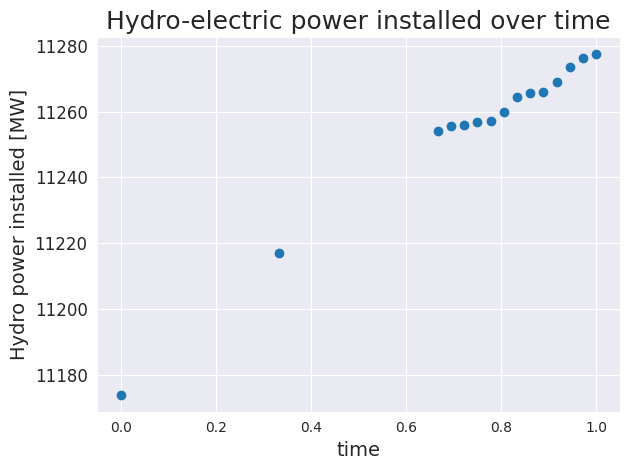

In [348]:
plt.scatter(df_hydro_nord['time'],df_hydro_nord['Idrico_installato'])
xtick = df_wind_nord['Anno']
plt.xlabel('time', fontsize = labelfontsize)
plt.ylabel('Hydro power installed [MW]', fontsize = labelfontsize)
plt.yticks(fontsize = ticksfontsize)
plt.title('Hydro-electric power installed over time', fontsize = titlefontsize)
plt.tight_layout()

plt.show()

In [390]:
b_linear_1 = df_hydro_nord[df_hydro_nord['Anno']==2021]['Idrico_installato'].values[0]
y_linear_1 = np.array(df_hydro_nord[df_hydro_nord['time']< 0.67]['Idrico_installato'])- b_linear_1
a_linear_1 = np.polyfit(np.array(df_hydro_nord[df_hydro_nord['time']< 0.67]['time']), np.array(y_linear_1), 1)[0]
linear_fit_1 = (df_actuals[df_actuals['time']< 0.67]['time'])*a_linear_1 + b_linear_1


ValueError: x and y must be the same size

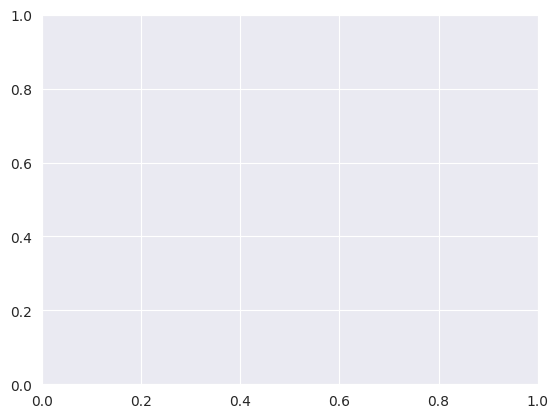

In [385]:
plt.scatter(df_actuals[df_actuals['time']< 0.67]['time'],y_linear_1+b_linear_1)
plt.plot(df_hydro_nord[df_hydro_nord['time']< 0.67]['time'],linear_fit_1,color='red',label='Linear fit')
xtick = df_hydro_nord['Anno']
plt.xlabel('time', fontsize = labelfontsize)
plt.ylabel('Hydro power installed [MW]', fontsize = labelfontsize)
plt.yticks(fontsize = ticksfontsize)
plt.title('Hydro-electric power installed over time', fontsize = titlefontsize)
plt.tight_layout()

fit_text = f'y = ax+c \na = {round(a_linear_1,1)}\nb = {round(b_linear_1,1)}' 
plt.text(0.05, 0.95, fit_text, transform=plt.gca().transAxes,
         fontsize=ticksfontsize, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6))
plt.show()

In [389]:
b_linear_2 = df_hydro_nord.iloc[2]['Idrico_installato']
y_linear_2 = np.array(df_hydro_nord[df_hydro_nord['time']> 0.66]['Idrico_installato'])- b_linear_2
a_linear_2 = np.polyfit(np.array(df_hydro_nord[df_hydro_nord['time']> 0.66]['time']), np.array(y_linear_2), 1)[0]
linear_fit_2 = (df_actuals[df_actuals['time']> 0.66]['time']-0.6666667)*a_linear_2 + b_linear_2




ValueError: x and y must have same first dimension, but have shapes (3,) and (17672,)

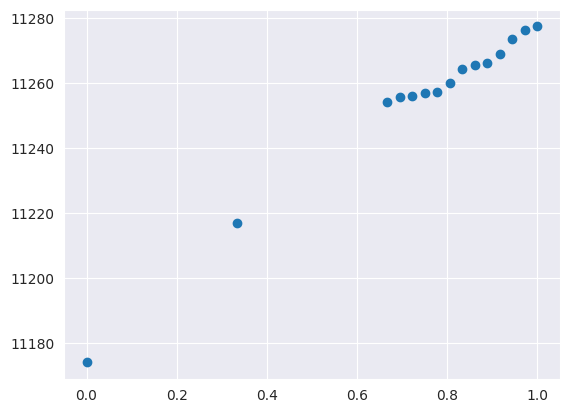

In [387]:
plt.scatter(df_hydro_nord['time'],df_hydro_nord['Idrico_installato'])
plt.plot(df_hydro_nord[df_hydro_nord['time']< 0.67]['time'],linear_fit_1,color='red',label='Linear fit 1')
plt.plot(df_hydro_nord[df_hydro_nord['time']> 0.66]['time'],linear_fit_2,color='red',label='Linear fit 2')
xtick = df_hydro_nord['Anno']
plt.xlabel('time', fontsize = labelfontsize)
plt.ylabel('Hydro power installed [MW]', fontsize = labelfontsize)
plt.yticks(fontsize = ticksfontsize)
plt.title('Hydro-electric power installed over time', fontsize = titlefontsize)
plt.tight_layout()

fit_text = f'y = ax+b\na1 = {round(a_linear_1,1)}\nb1 = {round(b_linear_1,1)}\na2={round(a_linear_2,1)}\nb2 = {round(b_linear_2,1)}' 
plt.text(0.05, 0.95, fit_text, transform=plt.gca().transAxes,
         fontsize=ticksfontsize, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6))
plt.show()

In [388]:
df_actuals['detrended_hydro']=0.
df_actuals.loc[df_actuals['time']<0.6668,'detrended_hydro']=df_actuals.loc[df_actuals['time']<0.6668,'hydro']/linear_fit_1
df_actuals.loc[df_actuals['time']>0.6667,'detrended_hydro']=df_actuals.loc[df_actuals['time']>0.6667,'hydro']/linear_fit_2

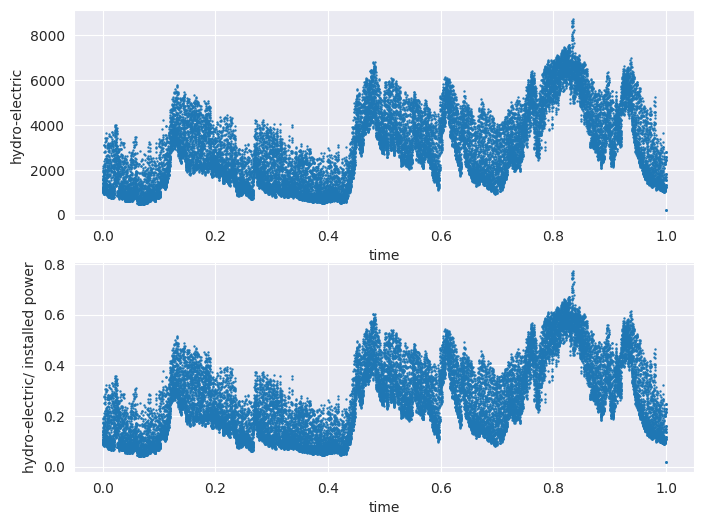

In [355]:
fig, ax = plt.subplots(nrows=2, figsize=[8,6])

ax[0].scatter(df_actuals['time'], df_actuals['hydro'], s = 0.5)

ax[0].set_xlabel('time')
ax[0].set_ylabel('hydro-electric')

ax[1].scatter(df_actuals['time'], df_actuals['detrended_hydro'], s = 0.5)
ax[1].set_xlabel('time')
ax[1].set_ylabel('hydro-electric/ installed power')

plt.show()

In [356]:

filename = 'output/normalized_actuals_MSTL.csv'
df_actuals.to_csv(filename) # saving normalized production data

In [357]:
df_actuals

,solar,wind,hydro,generation,load,node_id,time,detrended_solar,detrended_wind,detrended_hydro
date_time,,,,,,,,,,
2022-01-01 00:00:00+00:00,0.0,2.0,1110.0,6894.0,10583.0,IT_NORD,0.000000,0.0,6.646707,0.099338
2022-01-01 01:00:00+00:00,0.0,22.0,1063.0,6297.0,10054.0,IT_NORD,0.000038,0.0,6.365066,0.095132
2022-01-01 02:00:00+00:00,0.0,22.0,1057.0,5373.0,9573.0,IT_NORD,0.000076,0.0,6.328936,0.094595
2022-01-01 03:00:00+00:00,0.0,22.0,1089.0,4963.0,9402.0,IT_NORD,0.000114,0.0,6.520332,0.097458
2022-01-01 04:00:00+00:00,0.0,22.0,1053.0,5405.0,9689.0,IT_NORD,0.000152,0.0,6.304582,0.094236
...,...,...,...,...,...,...,...,...,...,...
2024-12-31 22:45:00+00:00,0.0,56.0,1216.0,10158.0,11958.0,IT_NORD,0.999848,0.0,5.755804,0.107815
2024-12-31 23:00:00+00:00,0.0,8.0,218.0,2110.0,11528.0,IT_NORD,0.999886,0.0,1.031879,0.019329
2024-12-31 23:15:00+00:00,0.0,8.0,214.0,2095.0,11695.0,IT_NORD,0.999924,0.0,1.012946,0.018974
